In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.regression import *

import xgboost
import catboost

## Test Data: Divide Test Data

In [3]:
#Import test data
test = pd.read_csv('test_all.csv')
test.head()

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,DepartureScheduled,ArrivalScheduled,BlockTimeScheduled,Adults,Children,Freight,Infants,Bags,DepartureDay,DepartureMonth,DepartureYear,DepartureTime,DepartureTimeOfDay,DepartureDay_cat,DepartureMonth_cat,Adults_wt,Children_wt,Bags_wt,Origin,Destination,Distance,Distance_cat,BlockTime_cat,AircraftType+Capacity,DepartureYear+Season,DepartureYear_cat,DepartureYear_cat2
0,181257208,4016,9HQAF,189,NG,Scheduled Flight,FR,Malta Air,2021-11-25 08:00:00,2021-11-25 09:10:00,70.0,175.0,4.0,0.0,0.0,11.0,25,11,2021,08:00:00,Morning,Weekend,Autumn,14647.5,130.0,182.957961,PSR,BGY,507.755360,Medium Haul,<90,NG189,2021 Autumn,2021-22,Relaxed Travel Restrictions
1,181195213,2037,EIDPZ,189,NG,Scheduled Flight,FR,Ryanair DAC,2022-03-18 06:00:00,2022-03-18 08:35:00,155.0,140.0,4.0,0.0,1.0,48.0,18,3,2022,06:00:00,Morning,Weekend,Spring,11718.0,130.0,798.796138,PMI,DTM,1382.913596,Medium Haul,>150,NG189,2022 Spring,2021-22,Relaxed Travel Restrictions
2,181128045,5084,EIEBR,189,NG,Scheduled Flight,FR,Ryanair DAC,2021-10-29 04:05:00,2021-10-29 05:35:00,90.0,49.0,4.0,0.0,0.0,12.0,29,10,2021,04:05:00,Late Night/Early Morning,Weekend,Autumn,4101.3,130.0,198.949811,PFO,CHQ,763.274192,Medium Haul,90-150,NG189,2021 Autumn,2021-22,Relaxed Travel Restrictions
3,178889497,2872,EIEMR,189,NG,Scheduled Flight,FR,Ryanair DAC,2020-01-10 07:55:00,2020-01-10 10:25:00,150.0,134.0,11.0,0.0,0.0,48.0,10,1,2020,07:55:00,Morning,Weekend,Winter,11215.8,357.5,795.780414,BGY,VNO,1485.674863,Medium Haul,90-150,NG189,2020 Winter,2019-20,Relaxed Travel Restrictions
4,178957284,5178,EIDCP,189,NG,Scheduled Flight,FR,Ryanair DAC,2019-11-22 19:30:00,2019-11-22 21:05:00,95.0,172.0,9.0,0.0,3.0,50.0,22,11,2019,19:30:00,Night,Weekend,Autumn,14396.4,292.5,831.983696,STN,BLL,724.690408,Medium Haul,90-150,NG189,2019 Autumn,2019-20,Relaxed Travel Restrictions


In [4]:
test_data = test.copy()

In [5]:
#Drop unnecessary columns

test = test.drop(['FlightID','FlightNumber','AircraftRegistration',
              'Carrier','AircraftCapacity','AircraftTypeGroup',
              'AOCDescription','DepartureScheduled','ArrivalScheduled',
              'Adults','Children','Infants','Bags',
              'DepartureDay','DepartureMonth','DepartureTime',
              'Origin','Destination','DepartureYear+Season','DepartureYear_cat',
              'BlockTime_cat'],axis=1)

In [6]:
test_NG189 = test[test['AircraftType+Capacity']=='NG189']
test_Max197 = test[test['AircraftType+Capacity']=='Max197']
test_Airbus180 = test[test['AircraftType+Capacity']=='Airbus180']
test_NG148 = test[test['AircraftType+Capacity']=='NG148']

test_NG189.shape, test_Max197.shape, test_Airbus180.shape, test_NG148.shape

((178990, 14), (5544, 14), (6761, 14), (14, 14))

In [7]:
NG189 = test_data[test_data['AircraftType+Capacity']=='NG189']
Max197 = test_data[test_data['AircraftType+Capacity']=='Max197']
Airbus180 = test_data[test_data['AircraftType+Capacity']=='Airbus180']
NG148 = test_data[test_data['AircraftType+Capacity']=='NG148']

# Train data

In [8]:
#Import dataset
df = pd.read_csv('train_all.csv')
df.head()

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,DepartureScheduled,ArrivalScheduled,BlockTimeScheduled,Adults,Children,Freight,Infants,Bags,TeledyneRampWeight,DepartureDay,DepartureMonth,DepartureYear,DepartureTime,DepartureTimeOfDay,DepartureDay_cat,DepartureMonth_cat,Adults_wt,Children_wt,Bags_wt,Origin,Destination,Distance,Distance_cat,BlockTime_cat,AircraftType+Capacity,DepartureYear+Season,DepartureYear_cat,DepartureYear_cat2
0,181142302,221,SPRZK,197,Max,Scheduled Flight,FR,Ryanair Sun,2022-01-24 09:55:00,2022-01-24 12:30:00,155.0,112.0,6.0,0.0,2.0,43.0,62075.0,24,1,2022,09:55:00,Morning,Weekend,Winter,9374.4,195.0,715.491333,EMA,BUD,1578.757122,Medium Haul,>150,Max197,2022 Winter,2021-22,Relaxed Travel Restrictions
1,178908306,3373,9HQEC,189,NG,Scheduled Flight,FR,Malta Air,2020-03-09 09:00:00,2020-03-09 11:00:00,120.0,18.0,0.0,0.0,0.0,7.0,62002.0,9,3,2020,09:00:00,Morning,Weekend,Spring,1506.6,0.0,116.585000,TRN,MLA,1187.373797,Medium Haul,90-150,NG189,2020 Spring,2019-20,Peak Pandemic/Restricted Travel
2,178886981,2814,9HQCN,189,NG,Scheduled Flight,FR,Malta Air,2020-01-06 07:35:00,2020-01-06 08:50:00,75.0,126.0,5.0,0.0,0.0,19.0,58029.0,6,1,2020,07:35:00,Morning,Weekend,Winter,10546.2,162.5,315.716183,STN,CGN,492.464988,Short Haul,<90,NG189,2020 Winter,2019-20,Relaxed Travel Restrictions
3,180538798,6893,SPRKP,189,NG,Scheduled Flight,FR,Ryanair Sun,2020-12-11 07:15:00,2020-12-11 08:45:00,90.0,84.0,5.0,0.0,1.0,8.0,56070.0,11,12,2020,07:15:00,Morning,Weekend,Winter,7030.8,162.5,132.977778,DTM,KTW,810.037002,Medium Haul,90-150,NG189,2020 Winter,2019-20,Relaxed Travel Restrictions
4,178863684,2156,EIDWJ,189,NG,Scheduled Flight,FR,Ryanair DAC,2020-02-07 15:20:00,2020-02-07 18:05:00,165.0,175.0,2.0,0.0,0.0,47.0,68315.0,7,2,2020,15:20:00,Afternoon/Evening,Weekend,Winter,14647.5,65.0,782.251271,BHX,AGP,1767.697155,Medium Haul,>150,NG189,2020 Winter,2019-20,Relaxed Travel Restrictions


In [9]:
#Drop unnecessary columns

df = df.drop(['FlightID','FlightNumber','AircraftRegistration',
              'Carrier','AircraftCapacity','AircraftTypeGroup',
              'AOCDescription','DepartureScheduled','ArrivalScheduled',
              'Adults','Children','Infants','Bags',
              'DepartureDay','DepartureMonth','DepartureTime',
              'Origin','Destination','DepartureYear+Season','DepartureYear_cat',
              'BlockTime_cat'],axis=1)

In [10]:
train_NG189 = df[df['AircraftType+Capacity']=='NG189']
train_Max197 = df[df['AircraftType+Capacity']=='Max197']
train_Airbus180 = df[df['AircraftType+Capacity']=='Airbus180']
train_NG148 = df[df['AircraftType+Capacity']=='NG148']

train_NG189.shape, train_Max197.shape, train_Airbus180.shape, train_NG148.shape

((716856, 15), (22233, 15), (26057, 15), (90, 15))

# Predict on NG189

In [106]:
data = train_NG189.sample(frac=0.9, random_state=786)
data_unseen = train_NG189.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (645170, 15)
Unseen Data For Predictions (71686, 15)


In [107]:
model = setup(

    # Basic options
    data = data,
    target = "TeledyneRampWeight",
    train_size = 0.7,
    #ordinal_features = {'BlockTime_cat' : ['<90', '90-150', '>150'],
    #                   'Distance_cat': ['Short Haul', 'Medium Haul']},
    
    #bin_numeric_features = ['BlockTimeScheduled','Distance'],

    preprocess = True,
    
    #remove_outliers = True,
    #outliers_threshold = 0.01,

    # Feature normalization
    normalize = True,
    normalize_method = 'zscore',
    transformation = True, 
    transform_target = True,

    # Dealing with collinearity
    remove_multicollinearity = True,
    multicollinearity_threshold = 0.8,
    remove_perfect_collinearity = True,
    
    #feature_selection = True,

    # Cross-validation settings
    data_split_shuffle = True,
    data_split_stratify = False,
    fold_strategy = 'stratifiedkfold',
    fold = 5,
    fold_shuffle = False,
    fold_groups = None,


    # Paralellization options
    n_jobs = -1,
    use_gpu = False,

    # MLFlow experiments registry
    log_experiment = True,
    experiment_name = "ryan_ng189"
)

,Description,Value
0,session_id,3013
1,Target,TeledyneRampWeight
2,Original Data,"(645170, 15)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(451618, 24)"


In [13]:
models = compare_models(exclude = ['et', 'knn', 'ransac'], n_select = 3, fold = 3, sort = "MAE")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1130.9472,13004082.1945,3606.0748,0.6028,0.0420,0.0171,40.6267
lightgbm,Light Gradient Boosting Machine,1137.5576,13012880.2799,3607.3019,0.6025,0.0420,0.0172,4.8867
xgboost,Extreme Gradient Boosting,1149.7330,13093205.6667,3618.4154,0.6001,0.0422,0.0174,66.8100
gbr,Gradient Boosting Regressor,1150.0360,13068303.0960,3614.9796,0.6008,0.0422,0.0174,52.5300
rf,Random Forest Regressor,1243.9085,13520703.6725,3677.0185,0.5870,0.0435,0.0189,106.2767
huber,Huber Regressor,1439.0560,14192850.7303,3767.3089,0.5665,0.0457,0.0222,6.8833
lar,Least Angle Regression,1456.5640,14179819.8754,3765.5786,0.5669,0.0456,0.0225,1.7433
br,Bayesian Ridge,1456.5678,14179436.0984,3765.5275,0.5669,0.0456,0.0225,1.0933
ridge,Ridge Regression,1458.1809,14185225.3333,3766.2974,0.5667,0.0457,0.0225,2.0800
lr,Linear Regression,1458.1812,14185208.3333,3766.2952,0.5667,0.0457,0.0225,5.3100


### Create

In [108]:
model_1 = create_model('catboost', fold = 10, round = 2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1135.46,13072827.58,3615.64,0.60,0.04,0.02
1,1131.07,12737385.56,3568.95,0.61,0.04,0.02
2,1117.87,12287650.49,3505.37,0.62,0.04,0.02
3,1129.31,13015376.78,3607.68,0.60,0.04,0.02
4,1127.52,13016860.29,3607.89,0.60,0.04,0.02
5,1128.58,13314162.80,3648.86,0.60,0.04,0.02
6,1137.27,13486901.22,3672.45,0.59,0.04,0.02
7,1121.92,12694802.92,3562.98,0.61,0.04,0.02
8,1127.13,12868868.63,3587.32,0.60,0.04,0.02


### Tune

In [109]:
tuned_m1 = tune_model(model_1, optimize = 'MAE', fold = 10,
                      choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1139.0646,13076717.6716,3616.1745,0.6019,0.0421,0.0172
1,1136.8451,12760062.8367,3572.1230,0.6055,0.0418,0.0172
2,1122.3526,12300554.3111,3507.2146,0.6156,0.0411,0.0170
3,1133.7082,13033143.6028,3610.1445,0.6012,0.0421,0.0171
4,1131.2233,13034001.5656,3610.2634,0.6019,0.0421,0.0171
5,1132.4186,13327044.5883,3650.6225,0.5963,0.0423,0.0171
6,1140.1080,13491432.7147,3673.0686,0.5917,0.0428,0.0172
7,1126.5251,12715896.6324,3565.9356,0.6114,0.0412,0.0171
8,1131.5191,12874409.5304,3588.0927,0.6046,0.0418,0.0171


### Bagging

In [110]:
bagged_m1 = ensemble_model(tuned_m1, choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1134.8046,13147538.7014,3625.9535,0.6007,0.0421,0.0171
1,1126.2107,12972070.8169,3601.6761,0.6032,0.0418,0.0170
2,1120.4156,12607897.4930,3550.7601,0.6104,0.0414,0.0170
3,1126.8444,12831456.1855,3582.1022,0.6066,0.0417,0.0171
4,1130.8798,13377112.4521,3657.4735,0.5937,0.0426,0.0171
Mean,1127.8310,12987215.1298,3603.5931,0.6029,0.0419,0.0170
Std,4.8273,263095.2824,36.4964,0.0057,0.0004,0.0001


/Users/sahanaroy/opt/anaconda3/envs/pycaret_full/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/sahanaroy/opt/anaconda3/envs/pycaret_full/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/sahanaroy/opt/anaconda3/envs/pycaret_full/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/sahanaroy/opt/anaconda3/envs/pyca

### Stacking 

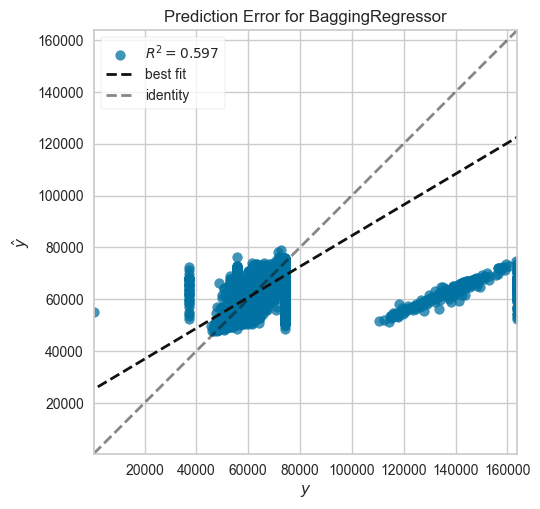

In [118]:
plot_model(bagged_m1, plot = 'error')

### Predict on unseen data

In [119]:
unseen_predictions = predict_model(bagged_m1, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1121.3257,12264947.0605,3502.1346,0.6163,0.0409,0.0170


,ServiceDescription,BlockTimeScheduled,Freight,TeledyneRampWeight,DepartureYear,DepartureTimeOfDay,DepartureDay_cat,DepartureMonth_cat,Adults_wt,Children_wt,Bags_wt,Distance,Distance_cat,AircraftType+Capacity,DepartureYear_cat2,Label
0,Scheduled Flight,80.0,0.0,62238.0,2021,Afternoon/Evening,Weekend,Summer,14145.3,65.0,882.735029,455.134165,Short Haul,NG189,Relaxed Travel Restrictions,63544.691538
1,Scheduled Flight,100.0,0.0,59444.0,2021,Afternoon/Evening,Weekend,Winter,9541.8,195.0,182.652250,865.147543,Medium Haul,NG189,Relaxed Travel Restrictions,59037.988533
2,Scheduled Flight,85.0,0.0,64233.0,2019,Night,Weekend,Autumn,14396.4,97.5,266.204343,546.207408,Medium Haul,NG189,Relaxed Travel Restrictions,64013.020994
3,Scheduled Flight,115.0,0.0,65249.0,2021,Morning,Weekend,Summer,13392.0,520.0,977.254545,1056.504204,Medium Haul,NG189,Relaxed Travel Restrictions,64794.716994
4,Scheduled Flight,245.0,0.0,71036.0,2020,Afternoon/Evening,Weekend,Winter,14731.2,227.5,1564.104108,2795.713358,Medium Haul,NG189,Relaxed Travel Restrictions,71978.026313


### Predict on test data

In [120]:
test_prediction1 = predict_model(bagged_m1, data=test_NG189)

In [121]:
test_prediction1.head()

,ServiceDescription,BlockTimeScheduled,Freight,DepartureYear,DepartureTimeOfDay,DepartureDay_cat,DepartureMonth_cat,Adults_wt,Children_wt,Bags_wt,Distance,Distance_cat,AircraftType+Capacity,DepartureYear_cat2,Label
0,Scheduled Flight,70.0,0.0,2021,Morning,Weekend,Autumn,14647.5,130.0,182.957961,507.755360,Medium Haul,NG189,Relaxed Travel Restrictions,62968.748982
1,Scheduled Flight,155.0,0.0,2022,Morning,Weekend,Spring,11718.0,130.0,798.796138,1382.913596,Medium Haul,NG189,Relaxed Travel Restrictions,64103.595041
2,Scheduled Flight,90.0,0.0,2021,Late Night/Early Morning,Weekend,Autumn,4101.3,130.0,198.949811,763.274192,Medium Haul,NG189,Relaxed Travel Restrictions,53056.047728
3,Scheduled Flight,150.0,0.0,2020,Morning,Weekend,Winter,11215.8,357.5,795.780414,1485.674863,Medium Haul,NG189,Relaxed Travel Restrictions,63729.241277
4,Scheduled Flight,95.0,0.0,2019,Night,Weekend,Autumn,14396.4,292.5,831.983696,724.690408,Medium Haul,NG189,Relaxed Travel Restrictions,64982.964264


<AxesSubplot:xlabel='Label', ylabel='Density'>

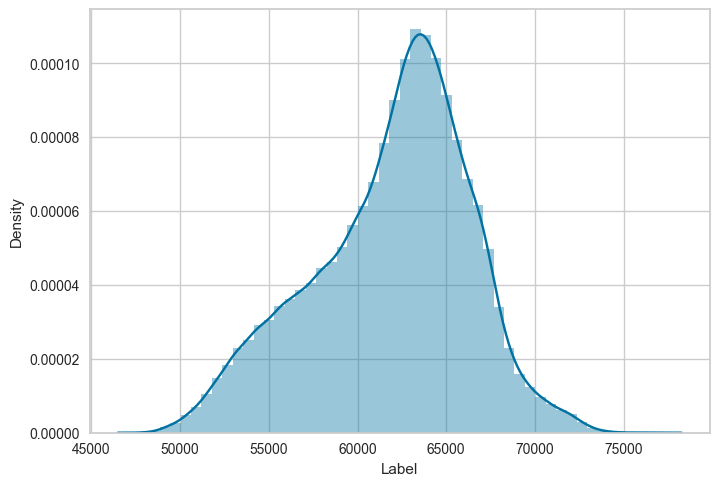

In [122]:
sns.distplot(test_prediction1['Label'])

In [123]:
NG189['TeledyneRampWeight'] = test_prediction1['Label']
submission1 = NG189[['FlightID','TeledyneRampWeight']].to_csv('submissions_11a.csv', index=False)

In [124]:
NG189[['FlightID','TeledyneRampWeight']].shape

(178990, 2)

# Predict on Max197

In [125]:
data = train_Max197.sample(frac=0.9, random_state=786)
data_unseen = train_Max197.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (20010, 15)
Unseen Data For Predictions (2223, 15)


In [126]:
model = setup(

    # Basic options
    data = data,
    target = "TeledyneRampWeight",
    train_size = 0.7,
    #ordinal_features = {'BlockTime_cat' : ['<90', '90-150', '>150'],
    #                   'Distance_cat': ['Short Haul', 'Medium Haul']},
    
    #bin_numeric_features = ['BlockTimeScheduled','Distance'],

    preprocess = True,
    
    #remove_outliers = True,
    #outliers_threshold = 0.01,

    # Feature normalization
    normalize = True,
    normalize_method = 'zscore',
    transformation = True, 
    transform_target = True,

    # Dealing with collinearity
    remove_multicollinearity = True,
    multicollinearity_threshold = 0.8,
    remove_perfect_collinearity = True,
    
    #feature_selection = True,

    # Cross-validation settings
    data_split_shuffle = True,
    data_split_stratify = False,
    fold_strategy = 'stratifiedkfold',
    fold = 5,
    fold_shuffle = False,
    fold_groups = None,


    # Paralellization options
    n_jobs = -1,
    use_gpu = False,

    # MLFlow experiments registry
    log_experiment = True,
    experiment_name = "ryan_max197"
)

,Description,Value
0,session_id,8616
1,Target,TeledyneRampWeight
2,Original Data,"(20010, 15)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(14006, 19)"


In [27]:
models = compare_models(exclude = ['et', 'knn', 'ransac'], n_select = 3, fold = 3, sort = "MAE")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,680.3119,930294.5493,964.4959,0.9433,0.0152,0.0107,1.3067
lightgbm,Light Gradient Boosting Machine,694.9757,958410.1971,978.9402,0.9416,0.0154,0.0109,0.3333
xgboost,Extreme Gradient Boosting,711.3251,1013252.6250,1006.5923,0.9382,0.0159,0.0112,0.8200
gbr,Gradient Boosting Regressor,711.7948,995922.9026,997.9394,0.9393,0.0157,0.0112,0.4500
rf,Random Forest Regressor,732.1931,1055544.8717,1027.3368,0.9356,0.0162,0.0115,1.4367
huber,Huber Regressor,967.3853,1679090.3593,1295.7777,0.8976,0.0205,0.0152,0.1267
lar,Least Angle Regression,979.0087,1670248.4238,1292.3509,0.8982,0.0205,0.0154,0.0600
br,Bayesian Ridge,979.1062,1670339.7242,1292.3855,0.8982,0.0205,0.0154,0.0600
ridge,Ridge Regression,979.1140,1670362.9583,1292.3944,0.8982,0.0205,0.0154,0.0267
lr,Linear Regression,979.1350,1670438.8750,1292.4240,0.8981,0.0205,0.0154,1.4133


### Create

In [135]:
model_2 = create_model('catboost', fold = 10, round = 2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,673.39,850658.77,922.31,0.95,0.01,0.01
1,667.91,895103.62,946.10,0.95,0.01,0.01
2,686.02,1015226.51,1007.58,0.94,0.02,0.01
3,691.69,983362.98,991.65,0.94,0.02,0.01
4,651.80,803934.18,896.62,0.95,0.01,0.01
5,705.11,941357.34,970.24,0.94,0.02,0.01
6,693.05,1000194.16,1000.10,0.94,0.02,0.01
7,647.15,799375.38,894.08,0.95,0.01,0.01
8,686.33,924286.82,961.40,0.94,0.02,0.01


### Tune

In [130]:
tuned_m2 = tune_model(model_2, optimize = 'MAE', fold = 10,
                      choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,693.7934,888990.5584,942.8630,0.9461,0.0148,0.0109
1,687.3521,941128.3088,970.1177,0.9431,0.0153,0.0108
2,711.3381,1073165.8932,1035.9372,0.9369,0.0164,0.0111
3,715.9528,1043597.5991,1021.5662,0.9378,0.0160,0.0112
4,665.9785,847182.9842,920.4254,0.9497,0.0145,0.0104
5,716.9552,982491.1416,991.2069,0.9404,0.0156,0.0112
6,717.5066,1062463.3857,1030.7586,0.9352,0.0162,0.0112
7,671.0783,893909.3820,945.4678,0.9447,0.0149,0.0105
8,697.0579,953897.3468,976.6767,0.9413,0.0153,0.0109


### Bagging

In [131]:
bagged_m2 = ensemble_model(model_2, choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,681.8241,910308.8119,954.1010,0.9448,0.0150,0.0107
1,686.1045,983204.6362,991.5668,0.9403,0.0157,0.0107
2,683.0398,924317.9681,961.4146,0.9443,0.0150,0.0107
3,681.8816,892342.8604,944.6390,0.9460,0.0148,0.0107
4,665.6291,834494.3707,913.5066,0.9496,0.0144,0.0104
Mean,679.6958,908933.7295,953.0456,0.9450,0.0150,0.0106
Std,7.2033,48106.5657,25.2548,0.0030,0.0004,0.0001


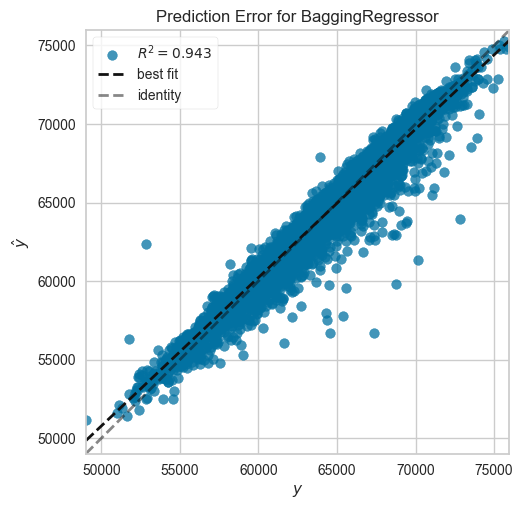

In [137]:
plot_model(bagged_m2, plot = 'error')

### Predict on unseen data

In [138]:
unseen_predictions = predict_model(bagged_m2, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,676.7057,914103.4151,956.0876,0.9439,0.0149,0.0106


,ServiceDescription,BlockTimeScheduled,Freight,TeledyneRampWeight,DepartureYear,DepartureTimeOfDay,DepartureDay_cat,DepartureMonth_cat,Adults_wt,Children_wt,Bags_wt,Distance,Distance_cat,AircraftType+Capacity,DepartureYear_cat2,Label
0,Scheduled Flight,270.0,0.0,70600.0,2022,Late Night/Early Morning,Weekend,Spring,12555.0,227.5,715.384780,2959.081331,Medium Haul,Max197,Relaxed Travel Restrictions,70076.845898
1,Scheduled Flight,100.0,0.0,58519.0,2022,Late Night/Early Morning,Weekend,Winter,8035.2,130.0,315.681200,828.227237,Medium Haul,Max197,Relaxed Travel Restrictions,59326.748485
2,Scheduled Flight,145.0,0.0,66065.0,2021,Morning,Weekend,Winter,11132.1,97.5,249.492463,1336.583141,Medium Haul,Max197,Relaxed Travel Restrictions,64504.642580
3,Scheduled Flight,175.0,0.0,63490.0,2021,Afternoon/Evening,Weekend,Winter,9207.0,227.5,631.968739,1724.492193,Medium Haul,Max197,Relaxed Travel Restrictions,63220.247878
4,Scheduled Flight,80.0,0.0,62474.0,2021,Afternoon/Evening,Weekend,Winter,11550.6,520.0,463.416364,648.822920,Medium Haul,Max197,Relaxed Travel Restrictions,63145.763578


### Predict on test data

In [139]:
test_prediction2 = predict_model(bagged_m2, data=test_Max197)

In [140]:
test_prediction2.head()

,ServiceDescription,BlockTimeScheduled,Freight,DepartureYear,DepartureTimeOfDay,DepartureDay_cat,DepartureMonth_cat,Adults_wt,Children_wt,Bags_wt,Distance,Distance_cat,AircraftType+Capacity,DepartureYear_cat2,Label
10,Scheduled Flight,105.0,0.0,2022,Afternoon/Evening,Weekend,Spring,11801.7,227.5,332.715333,969.404633,Medium Haul,Max197,Relaxed Travel Restrictions,63712.253829
45,Scheduled Flight,110.0,0.0,2021,Morning,Weekend,Autumn,9709.2,325.0,513.832381,1019.538919,Medium Haul,Max197,Relaxed Travel Restrictions,61842.745010
97,Scheduled Flight,135.0,0.0,2022,Afternoon/Evening,Weekend,Winter,12889.8,487.5,597.280000,1345.571717,Medium Haul,Max197,Relaxed Travel Restrictions,66398.390490
180,Scheduled Flight,65.0,234.0,2022,Late Night/Early Morning,Weekend,Spring,12471.3,130.0,299.562662,357.658072,Short Haul,Max197,Relaxed Travel Restrictions,62921.309688
210,Scheduled Flight,250.0,910.0,2021,Afternoon/Evening,Weekend,Winter,11299.5,65.0,1164.822993,2546.567004,Medium Haul,Max197,Relaxed Travel Restrictions,68415.279164


<AxesSubplot:xlabel='Label', ylabel='Density'>

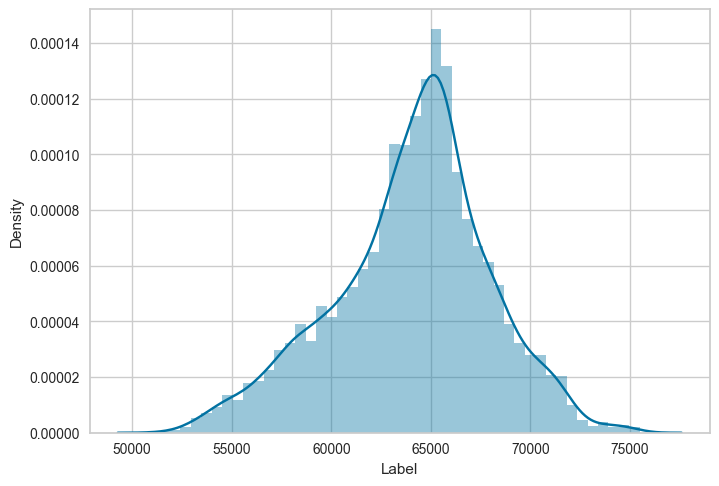

In [141]:
sns.distplot(test_prediction2['Label'])

In [142]:
Max197['TeledyneRampWeight'] = test_prediction2['Label']
submission2 = Max197[['FlightID','TeledyneRampWeight']].to_csv('submissions_11b.csv', index=False)

In [143]:
Max197[['FlightID','TeledyneRampWeight']].shape

(5544, 2)

# Predict on Airbus180

In [144]:
data = train_Airbus180.sample(frac=0.9, random_state=786)
data_unseen = train_Airbus180.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (23451, 15)
Unseen Data For Predictions (2606, 15)


In [145]:
model = setup(

    # Basic options
    data = data,
    target = "TeledyneRampWeight",
    train_size = 0.7,
    #ordinal_features = {'BlockTime_cat' : ['<90', '90-150', '>150'],
    #                   'Distance_cat': ['Short Haul', 'Medium Haul']},
    
    #bin_numeric_features = ['BlockTimeScheduled','Distance'],

    preprocess = True,
    
    #remove_outliers = True,
    #outliers_threshold = 0.01,

    # Feature normalization
    normalize = True,
    normalize_method = 'zscore',
    transformation = True, 
    transform_target = True,

    # Dealing with collinearity
    remove_multicollinearity = True,
    multicollinearity_threshold = 0.8,
    remove_perfect_collinearity = True,
    
    #feature_selection = True,

    # Cross-validation settings
    data_split_shuffle = True,
    data_split_stratify = False,
    fold_strategy = 'stratifiedkfold',
    fold = 5,
    fold_shuffle = False,
    fold_groups = None,


    # Paralellization options
    n_jobs = -1,
    use_gpu = False,

    # MLFlow experiments registry
    log_experiment = True,
    experiment_name = "ryan_airbus180"
)

,Description,Value
0,session_id,5756
1,Target,TeledyneRampWeight
2,Original Data,"(23451, 15)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(16415, 21)"


In [63]:
models = compare_models(exclude = ['et', 'knn', 'ransac'], n_select = 3, fold = 3, sort = "MAE")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1377.0625,4766979.4658,2183.2039,0.7580,0.0370,0.0233,1.1900
lightgbm,Light Gradient Boosting Machine,1380.9774,4795397.0577,2189.5488,0.7565,0.0371,0.0234,0.2267
gbr,Gradient Boosting Regressor,1405.1834,4883321.8055,2209.5807,0.7521,0.0375,0.0238,0.5033
huber,Huber Regressor,1428.6363,5878194.6491,2424.1824,0.7015,0.0410,0.0246,0.1067
xgboost,Extreme Gradient Boosting,1459.3725,5234553.1667,2287.6181,0.7342,0.0386,0.0247,0.7933
rf,Random Forest Regressor,1466.3965,5222152.9244,2284.9092,0.7348,0.0387,0.0248,1.7733
br,Bayesian Ridge,1557.9565,5485657.9215,2341.9555,0.7215,0.0397,0.0266,0.0300
ridge,Ridge Regression,1558.5367,5486437.8333,2342.1211,0.7214,0.0397,0.0266,0.0600
lr,Linear Regression,1558.7871,5487405.3333,2342.3263,0.7214,0.0397,0.0266,1.1300
omp,Orthogonal Matching Pursuit,1654.0756,6144889.0486,2478.7379,0.6880,0.0419,0.0282,0.0600


### Create

In [146]:
model_3 = create_model('catboost', fold = 10, round = 2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1356.88,4189026.35,2046.71,0.79,0.03,0.02
1,1428.63,5263469.39,2294.23,0.72,0.04,0.02
2,1305.91,4219594.35,2054.17,0.78,0.03,0.02
3,1381.18,4806520.91,2192.38,0.75,0.04,0.02
4,1368.65,4715764.87,2171.58,0.76,0.04,0.02
5,1324.45,4285473.47,2070.14,0.78,0.04,0.02
6,1348.86,4696202.49,2167.07,0.76,0.04,0.02
7,1346.86,4780848.10,2186.52,0.76,0.04,0.02
8,1363.66,4797199.74,2190.25,0.76,0.04,0.02


### Tune

In [147]:
tuned_m3 = tune_model(model_3, optimize = 'MAE', fold = 10,
                      choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1354.1858,4161987.1737,2040.0949,0.7905,0.0344,0.0228
1,1440.3499,5257151.6518,2292.8479,0.7214,0.0390,0.0245
2,1326.5242,4240534.6758,2059.2559,0.7772,0.0348,0.0224
3,1398.9257,4804135.7539,2191.8339,0.7502,0.0371,0.0237
4,1401.0547,4790773.0579,2188.7835,0.7540,0.0370,0.0238
5,1312.1413,4241096.2941,2059.3922,0.7818,0.0351,0.0222
6,1358.3812,4807546.7826,2192.6119,0.7533,0.0374,0.0231
7,1339.8766,4722628.6348,2173.1610,0.7602,0.0366,0.0227
8,1388.2738,4950431.5636,2224.9565,0.7510,0.0382,0.0237


### Bagging

In [150]:
bagged_m3 = ensemble_model(model_3, choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1391.1087,4684689.2241,2164.4143,0.7617,0.0365,0.0235
1,1369.4554,4836805.5942,2199.2739,0.7478,0.0375,0.0233
2,1325.5280,4375571.5278,2091.7867,0.7740,0.0353,0.0224
3,1338.4883,4599335.5683,2144.6062,0.7649,0.0363,0.0227
4,1389.0724,4836391.1023,2199.1796,0.7504,0.0374,0.0236
Mean,1362.7306,4666558.6033,2159.8521,0.7598,0.0366,0.0231
Std,26.5185,171667.2651,39.9672,0.0096,0.0008,0.0005


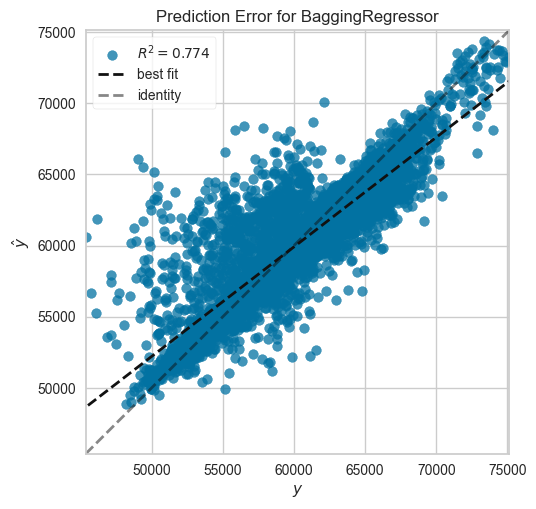

In [151]:
plot_model(bagged_m3, plot = 'error')

### Predict on unseen data

In [152]:
unseen_predictions = predict_model(bagged_m3, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1284.7913,4337497.9051,2082.6661,0.7801,0.0355,0.0219


,ServiceDescription,BlockTimeScheduled,Freight,TeledyneRampWeight,DepartureYear,DepartureTimeOfDay,DepartureDay_cat,DepartureMonth_cat,Adults_wt,Children_wt,Bags_wt,Distance,Distance_cat,AircraftType+Capacity,DepartureYear_cat2,Label
0,Scheduled Flight,65.0,0.0,52417.0,2021,Night,Weekday,Autumn,9709.2,195.0,616.292720,454.863487,Short Haul,Airbus180,Relaxed Travel Restrictions,58376.662145
1,Scheduled Flight,140.0,0.0,56500.0,2020,Morning,Weekend,Autumn,5524.2,0.0,482.995000,1369.690151,Medium Haul,Airbus180,Peak Pandemic/Restricted Travel,56591.002007
2,Scheduled Flight,130.0,0.0,51673.0,2021,Morning,Weekend,Autumn,7700.4,97.5,532.646667,1298.583552,Medium Haul,Airbus180,Relaxed Travel Restrictions,57764.615872
3,Scheduled Flight,125.0,0.0,57171.0,2021,Afternoon/Evening,Weekend,Autumn,7281.9,32.5,467.318444,1187.587491,Medium Haul,Airbus180,Relaxed Travel Restrictions,57455.994880
4,Scheduled Flight,120.0,0.0,54703.0,2021,Morning,Weekend,Winter,3515.4,0.0,83.275000,1099.076313,Medium Haul,Airbus180,Relaxed Travel Restrictions,53622.772738


### Predict on test data

In [153]:
test_prediction3 = predict_model(bagged_m3, data=test_Airbus180)

In [154]:
test_prediction3.head()

,ServiceDescription,BlockTimeScheduled,Freight,DepartureYear,DepartureTimeOfDay,DepartureDay_cat,DepartureMonth_cat,Adults_wt,Children_wt,Bags_wt,Distance,Distance_cat,AircraftType+Capacity,DepartureYear_cat2,Label
21,Scheduled Flight,75.0,0.0,2022,Morning,Weekend,Spring,12722.4,32.5,466.156078,494.134361,Short Haul,Airbus180,Relaxed Travel Restrictions,59562.983397
123,Scheduled Flight,115.0,0.0,2021,Afternoon/Evening,Weekend,Winter,7449.3,0.0,516.305000,1031.902436,Medium Haul,Airbus180,Relaxed Travel Restrictions,56997.082251
143,Scheduled Flight,120.0,0.0,2022,Late Night/Early Morning,Weekday,Winter,10462.5,97.5,299.658837,1099.076313,Medium Haul,Airbus180,Relaxed Travel Restrictions,61346.035805
168,Scheduled Flight,95.0,0.0,2021,Morning,Weekend,Summer,11215.8,325.0,515.498367,786.207427,Medium Haul,Airbus180,Relaxed Travel Restrictions,60562.688040
187,Scheduled Flight,110.0,0.0,2021,Afternoon/Evening,Weekend,Autumn,11132.1,130.0,465.945362,1067.661596,Medium Haul,Airbus180,Relaxed Travel Restrictions,61145.106258


<AxesSubplot:xlabel='Label', ylabel='Density'>

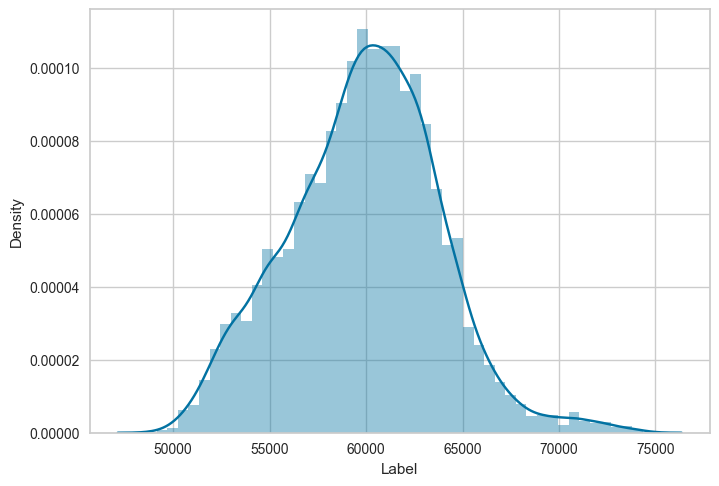

In [155]:
sns.distplot(test_prediction3['Label'])

In [156]:
Airbus180['TeledyneRampWeight'] = test_prediction3['Label']
submission3 = Airbus180[['FlightID','TeledyneRampWeight']].to_csv('submissions_11c.csv', index=False)

In [157]:
Airbus180[['FlightID','TeledyneRampWeight']].shape

(6761, 2)

# Predict on NG148

In [158]:
data = train_NG148.sample(frac=0.9, random_state=786)
data_unseen = train_NG148.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (81, 15)
Unseen Data For Predictions (9, 15)


In [159]:
model = setup(

    # Basic options
    data = data,
    target = "TeledyneRampWeight",
    train_size = 0.7,
    #ordinal_features = {'BlockTime_cat' : ['<90', '90-150', '>150'],
    #                   'Distance_cat': ['Short Haul', 'Medium Haul']},
    
    #bin_numeric_features = ['BlockTimeScheduled','Distance'],

    preprocess = True,
    
    #remove_outliers = True,
    #outliers_threshold = 0.01,

    # Feature normalization
    normalize = True,
    normalize_method = 'zscore',
    transformation = True, 
    transform_target = True,

    # Dealing with collinearity
    remove_multicollinearity = True,
    multicollinearity_threshold = 0.8,
    remove_perfect_collinearity = True,
    
    #feature_selection = True,

    # Cross-validation settings
    data_split_shuffle = True,
    data_split_stratify = False,
    fold_strategy = 'stratifiedkfold',
    fold = 5,
    fold_shuffle = False,
    fold_groups = None,


    # Paralellization options
    n_jobs = -1,
    use_gpu = False,

    # MLFlow experiments registry
    log_experiment = True,
    experiment_name = "ryan_ng148"
)

,Description,Value
0,session_id,6119
1,Target,TeledyneRampWeight
2,Original Data,"(81, 15)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(56, 19)"


In [86]:
models = compare_models(fold = 2, sort = "MAE")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1103.6310,2108768.2226,1449.2962,0.7420,0.0278,0.0211,0.1100
br,Bayesian Ridge,1125.5385,1999612.4827,1409.7897,0.7667,0.0269,0.0215,0.0250
catboost,CatBoost Regressor,1205.0428,2336046.5485,1519.0358,0.7304,0.0290,0.0230,1.2800
et,Extra Trees Regressor,1267.1471,2709879.3952,1633.8887,0.6885,0.0313,0.0243,0.0950
gbr,Gradient Boosting Regressor,1272.9923,2575250.1583,1596.8449,0.6812,0.0304,0.0243,0.0400
knn,K Neighbors Regressor,1278.2750,2321430.5410,1523.5840,0.7225,0.0292,0.0245,0.0200
par,Passive Aggressive Regressor,1302.6973,2894281.2525,1696.3406,0.6620,0.0320,0.0248,0.0150
ada,AdaBoost Regressor,1315.6407,2633800.9183,1617.8650,0.6761,0.0309,0.0252,0.0600
omp,Orthogonal Matching Pursuit,1399.8969,2824549.7367,1680.2967,0.6593,0.0324,0.0269,0.0150
dt,Decision Tree Regressor,1490.6953,3502029.0543,1870.7862,0.5839,0.0360,0.0286,0.0150


### Create

In [160]:
model_4 = create_model('rf', fold = 2, round = 2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1074.27,1803054.16,1342.78,0.78,0.03,0.02
1,1310.73,3042439.45,1744.26,0.65,0.03,0.02
Mean,1192.50,2422746.81,1543.52,0.71,0.03,0.02
Std,118.23,619692.65,200.74,0.06,0.00,0.00


In [161]:
model_4b = create_model('br', fold = 2, round = 2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1092.84,1549010.57,1244.59,0.81,0.02,0.02
1,1324.98,2789112.82,1670.06,0.68,0.03,0.03
Mean,1208.91,2169061.69,1457.33,0.74,0.03,0.02
Std,116.07,620051.12,212.74,0.06,0.00,0.00


### Tune

In [162]:
tuned_m4 = tune_model(model_4, optimize = 'MAE', fold = 2,
                      choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1273.2443,2402867.3651,1550.1185,0.7017,0.0302,0.0247
1,1499.9029,3763800.3444,1940.0516,0.5683,0.0368,0.0283
Mean,1386.5736,3083333.8548,1745.0851,0.6350,0.0335,0.0265
Std,113.3293,680466.4897,194.9666,0.0667,0.0033,0.0018


In [163]:
tuned_m4b = tune_model(model_4b, optimize = 'MAE', fold = 2,
                      choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1096.0053,1551987.5038,1245.7879,0.8073,0.0242,0.0213
1,1324.2987,2783559.2428,1668.4002,0.6807,0.0322,0.0255
Mean,1210.1520,2167773.3733,1457.0941,0.7440,0.0282,0.0234
Std,114.1467,615785.8695,211.3061,0.0633,0.0040,0.0021


### Bagging

In [164]:
bagged_m4 = ensemble_model(model_4, fold = 2, choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1235.6621,2184229.1731,1477.9138,0.7289,0.0290,0.0241
1,1442.3365,3382545.5882,1839.1698,0.6120,0.0349,0.0273
Mean,1338.9993,2783387.3807,1658.5418,0.6704,0.0320,0.0257
Std,103.3372,599158.2076,180.6280,0.0584,0.0029,0.0016


In [165]:
bagged_m4b = ensemble_model(model_4b, fold = 2, choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1052.8014,1593751.2409,1262.4386,0.8022,0.0249,0.0207
1,1330.3868,2548608.8155,1596.4363,0.7076,0.0307,0.0256
Mean,1191.5941,2071180.0282,1429.4374,0.7549,0.0278,0.0232
Std,138.7927,477428.7873,166.9988,0.0473,0.0029,0.0025


### Stacking 

In [166]:
stack_4 = stack_models([model_4, bagged_m4b], fold = 2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1573.8806,3805950.3685,1950.8845,0.5275,0.0375,0.0304
1,1524.9197,4303652.0386,2074.5245,0.5063,0.0404,0.0291
Mean,1549.4001,4054801.2036,2012.7045,0.5169,0.0389,0.0297
Std,24.4805,248850.8350,61.8200,0.0106,0.0014,0.0006


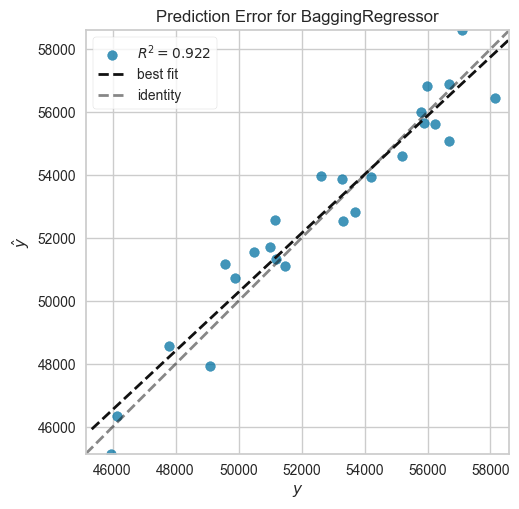

In [167]:
plot_model(bagged_m4b, plot = 'error')

### Predict on unseen data

In [168]:
unseen_predictions = predict_model(bagged_m4b, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1039.9511,1712263.2612,1308.5348,0.8843,0.0252,0.0199


,ServiceDescription,BlockTimeScheduled,Freight,TeledyneRampWeight,DepartureYear,DepartureTimeOfDay,DepartureDay_cat,DepartureMonth_cat,Adults_wt,Children_wt,Bags_wt,Distance,Distance_cat,AircraftType+Capacity,DepartureYear_cat2,Label
0,Scheduled Flight,85.0,0.0,52678.0,2020,Night,Weekend,Summer,4938.3,195.0,132.497846,470.666874,Short Haul,NG148,Peak Pandemic/Restricted Travel,50373.881070
1,Scheduled Flight,65.0,0.0,47671.0,2020,Late Night/Early Morning,Weekend,Autumn,4185.0,0.0,299.790000,321.504003,Short Haul,NG148,Peak Pandemic/Restricted Travel,49642.265802
2,Scheduled Flight,145.0,0.0,60642.0,2022,Morning,Weekend,Spring,11299.5,130.0,515.408453,1508.794719,Medium Haul,NG148,Relaxed Travel Restrictions,58815.675376
3,Scheduled Flight,120.0,0.0,56397.0,2021,Morning,Weekend,Autumn,9960.3,65.0,582.343595,921.140012,Medium Haul,NG148,Relaxed Travel Restrictions,56138.279048
4,Scheduled Flight,95.0,0.0,54002.0,2022,Morning,Weekend,Spring,6193.8,32.5,266.705263,795.716122,Medium Haul,NG148,Relaxed Travel Restrictions,53298.808122


### Predict on test data

In [169]:
test_prediction4 = predict_model(tuned_m4b, data=test_NG148)

In [170]:
test_prediction4.head()

,ServiceDescription,BlockTimeScheduled,Freight,DepartureYear,DepartureTimeOfDay,DepartureDay_cat,DepartureMonth_cat,Adults_wt,Children_wt,Bags_wt,Distance,Distance_cat,AircraftType+Capacity,DepartureYear_cat2,Label
15085,Scheduled Flight,170.0,0.0,2021,Night,Weekend,Summer,3850.2,260.0,313.616111,1832.810851,Medium Haul,NG148,Relaxed Travel Restrictions,52740.055141
18105,Charter Flight,55.0,0.0,2021,Morning,Weekend,Spring,2176.2,0.0,1232.470000,265.015355,Short Haul,NG148,Relaxed Travel Restrictions,49036.664587
23619,Scheduled Flight,155.0,0.0,2020,Night,Weekend,Summer,5607.9,162.5,464.385833,1433.508378,Medium Haul,NG148,Peak Pandemic/Restricted Travel,53224.271978
64569,Scheduled Flight,80.0,0.0,2020,Morning,Weekend,Summer,4436.1,227.5,165.377500,484.447637,Short Haul,NG148,Peak Pandemic/Restricted Travel,50363.987130
66425,Scheduled Flight,95.0,0.0,2021,Morning,Weekend,Winter,1422.9,97.5,99.661429,795.716122,Medium Haul,NG148,Relaxed Travel Restrictions,49044.832067


<AxesSubplot:xlabel='Label', ylabel='Density'>

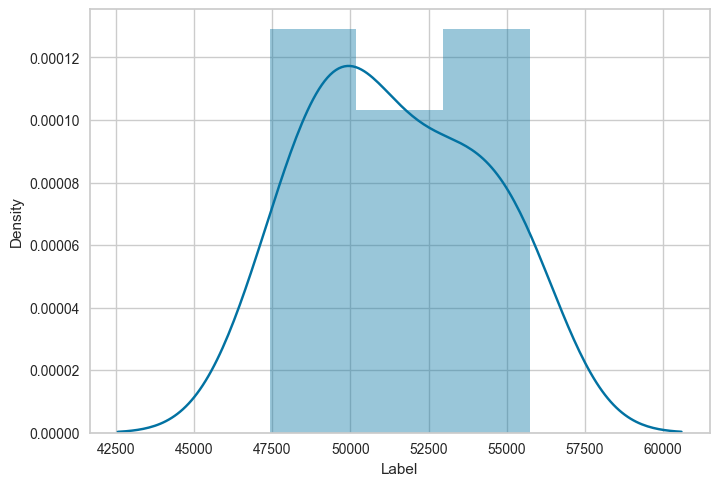

In [171]:
sns.distplot(test_prediction4['Label'])

In [172]:
NG148['TeledyneRampWeight'] = test_prediction4['Label']
submission4 = NG148[['FlightID','TeledyneRampWeight']].to_csv('submissions_11d.csv', index=False)

In [173]:
NG148[['FlightID','TeledyneRampWeight']].shape

(14, 2)

# Combining submissions

In [175]:
sub1 = pd.read_csv('submissions_11a.csv')
sub2 = pd.read_csv('submissions_11b.csv')
sub3 = pd.read_csv('submissions_11c.csv')
sub4 = pd.read_csv('submissions_11d.csv')

In [176]:
sub = pd.concat([sub1,sub2,sub3,sub4])
sub.head()

,FlightID,TeledyneRampWeight
0,181257208,62968.748982
1,181195213,64103.595041
2,181128045,53056.047728
3,178889497,63729.241277
4,178957284,64982.964264


<AxesSubplot:xlabel='TeledyneRampWeight', ylabel='Density'>

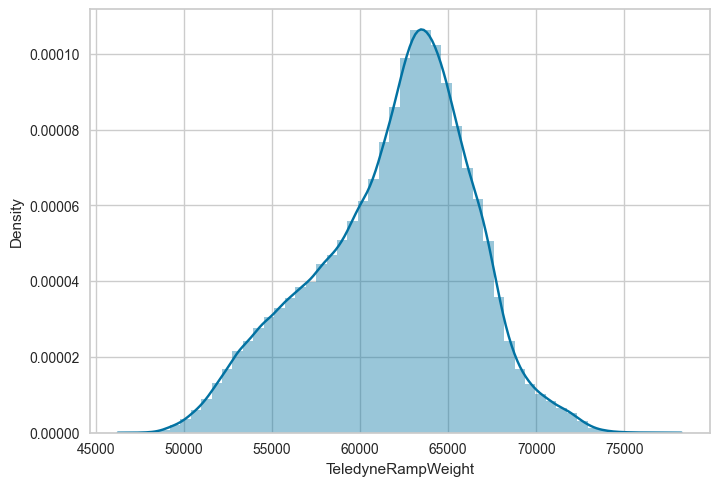

In [177]:
sns.distplot(sub['TeledyneRampWeight'])

In [178]:
sub.to_csv('submissions_11.csv', index=False)

In [179]:
sub.shape

(191309, 2)